# Fitting a FLMP
In this notebook, we will fit a Fuzzy Logical Model of Perception (FLMP) to audiovisual speech perception data.

In [16]:
import numpy as np
from glob import glob

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from scipy.special import comb
from scipy.optimize import minimize

## Prepare Data
The data consists of five text files, each containing seven rows and five columns, where:
- Row 1: Audiotorial data
- Row 2: Visual data
- Rows 3-7: Audiovisual data
    - a combination of rows 1 and 2
    - visual goes from 'b' (row 3) to 'd' (row 7) 
    - audio goes from 'b' (col 1) to 'd' (col 5)

In [2]:
# get paths to data files
file_paths = glob("./data/*.txt")

# load all data into a single array
data = np.array([np.loadtxt(fname) for fname in file_paths])
N, M, K = data.shape

# define number of samples for each subject
n_samples = 24 

# split into the three different data types
# data_A = data[:, 0, :]
# data_V = data[:, 1, :]
# data_AV = data[:, 2:, :]

## Fit FLMP

In [3]:
# create softmax function
def baseline_softmax(x):
    x = np.concatenate([
        np.array([x]).flatten(), [0]
    ])
    e = np.exp(x)
    return e / e.sum()

# create our own pmf function
def binomial_pmf(k, n, p):
    return comb(n, k) * np.power(p, k) * np.power(1 - p, n - k)

In [4]:
def objective_function(theta, data, K_, n_samples=24):
    # extract audio and visual parameters
    theta_A = theta[0:K_]
    theta_V = theta[K_: ]

    # get probabilities for audio and visual
    # p_A = baseline_softmax(theta_A).reshape(-1,1)
    # p_V = baseline_softmax(theta_V).reshape(-1,1)
    p_A = np.array([baseline_softmax(t)[0] for t in theta_A]).reshape(-1,1)
    p_V = np.array([baseline_softmax(t)[0] for t in theta_V]).reshape(-1,1)
    # print(theta_A.shape, theta_V.shape)
    # print(p_A.shape, p_V.shape)

    # compute audiovisual probabilities by
    # taking the outer product for all combinations of audio and visual
    p_AV = (p_A @ p_V.T) / (p_A @ p_V.T + (1 - p_A) @ (1 - p_V).T)
    
    # compute the log-likelihoods
    probs = np.vstack([p_A.T, p_V.T, p_AV])
    L = np.log(binomial_pmf(data, n_samples, probs)).sum()
    # L_A = binom.logpmf(data[0], n_samples, p_A).flatten()
    # L_V = binom.logpmf(data[1], n_samples, p_V).flatten()
    # L_AV = binom.logpmf(data[2:], n_samples, p_AV).flatten()
    # L = np.concatenate([L_A, L_V, L_AV]).sum()

    # return the negative log-likelihood
    return -L

In [5]:
def flmp_fit(data, n_samples, K_):
    """Perform FLMP fit to data"""
    theta = np.zeros(K_*2)
    opt_result = minimize(objective_function, theta, args=(data, K_, n_samples))
    objective, theta_A, theta_V = (
        opt_result.fun, 
        (opt_result.x[0:K_]), 
        (opt_result.x[K_:])
    )
    return objective, theta_A, theta_V

In [8]:
# perform FLMP fit for each subject
theta_A = np.zeros((K, N))
theta_V = np.zeros((K, N))
neg_L = np.zeros(K)
p_set = []
for i in range(K):
    obj, tA, tV = flmp_fit(data[i], n_samples, K)

    # save results
    neg_L[i] = obj
    theta_A[i, :] = tA 
    theta_V[i, :] = tV
    # theta_A[i, :-1] = tA
    # theta_V[i, :-1] = tV

    p_A = np.array([baseline_softmax(t)[0] for t in tA]).reshape(-1,1)
    p_V = np.array([baseline_softmax(t)[0] for t in tV]).reshape(-1,1)
    p_AV = (p_A @ p_V.T) / (p_A @ p_V.T + (1 - p_A) @ (1 - p_V).T)
    p_set.append(np.vstack([p_A.T, p_V.T, p_AV]))

    # print results
    print(f'\nResults for subject {i+1}')
    print(f'Negative log-likelihood: {neg_L[i]}')
    print("Audio:", theta_A[i])
    print("Visual:", theta_V[i])


Results for subject 1
Negative log-likelihood: 70.25765786050766
Audio: [-4.78771534 -1.95605374 -0.25823505  1.4352679   1.67202819]
Visual: [-1.11834385  0.51165129  1.54670812  4.28161038  5.03519695]

Results for subject 2
Negative log-likelihood: 41.79765647023252
Audio: [-6.55473281 -1.91458405  0.34489206  3.09946728  3.87804733]
Visual: [-1.6323042   1.07303225  2.55000164  4.14860452  6.12230255]

Results for subject 3
Negative log-likelihood: 68.33041239058285
Audio: [-2.95926896 -1.13433532 -0.10648978  1.29981573  1.6059848 ]
Visual: [-1.5345231  -0.36988929  0.86865843  3.57910915  5.6509255 ]

Results for subject 4
Negative log-likelihood: 72.31480656268391
Audio: [-2.66352691 -1.96654459 -1.27082508  0.82708932  1.69431478]
Visual: [-3.69983168 -2.16532769 -1.17804289  2.62584332  4.25102986]

Results for subject 5
Negative log-likelihood: 73.023877790512
Audio: [-4.43200271 -2.15618125 -0.97970262  0.64690831  1.04513986]
Visual: [-3.56948512 -1.18540162  1.06838796  4

# Visualize Results

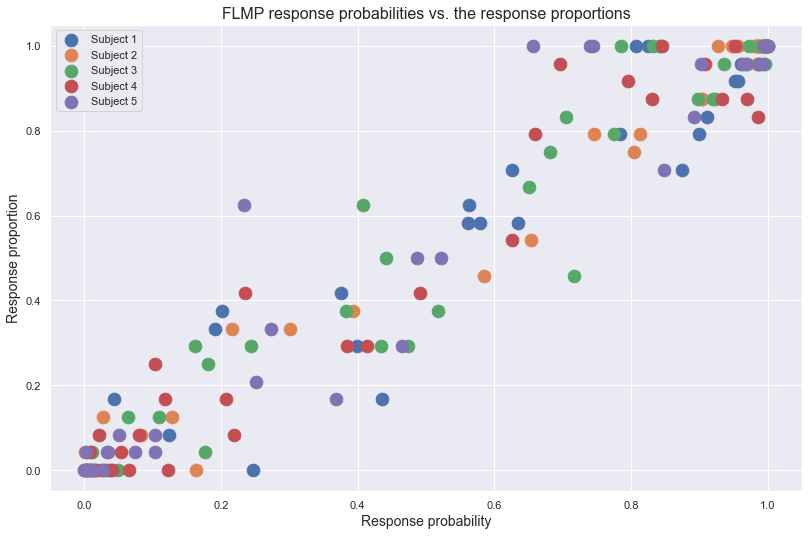

In [18]:
# define stuff to plot
x = p_set
y = list(data/24)

# plot FLMP response probabilities vs. response proportions
fig = plt.figure(figsize = (12,8))
ax1 = fig.add_subplot(111)
for idx in range(5):
    # labl = f''
    ax1.scatter(x[idx], y[idx], s=160, label=f'Subject {idx+1}')
plt.legend(loc='upper left')
plt.title("FLMP response probabilities vs. the response proportions", fontsize=16)
plt.xlabel('Response probability', fontsize=14)
plt.ylabel('Response proportion', fontsize=14)
plt.savefig('./visualizations/flmp_scatter.png', transparent=True)
plt.show()